# Handling missing data
This document (briefly) introduces the concept, categorization, and treatment of missing data.

## Classical categories of missing data
If we know how the missing data are generated, so-called missing data mechanisms, we can take into account why data are missing in data analysis. 

A particularly useful (and wide-known) framework for missingness categorizes missingness into the following three categories {cite:p}`little2019statistical`:

**MCAR (missing completely at random):** how data are missing is independent with any aspect of the data

**MAR (missing at random):** how data are missing depends on **observed** quantities, so-called *predictors, or independent variables*
- e.g., a person with certain characteristics (known) may not answer certain questions on a survey, *imagine reporting salary for different socio-economic classes*
- e.g., for certain inputs, a simulation model may crash or produce nonsensical outputs

**MNAR (missing not at random):** how data are missing depends on the **unobserved** quantities
- e.g., a pollutant sensor can only detect particles that are $> 0.1\mu\mathrm{m}$

Understanding the causes of missing data helps designing algorithms to handle missing data.  *However*, in reality, we often do not know the causes, or multiple causes exist in producing a data set.

- e.g., storm surges only occur in areas that get below the water level

**Cautionary note:** Where the data are missing matters, i.e., is a response value missing, is a predictor value missing, or do we not know what our analysis questions are yet?

## Treatment of missing data
General rules for treating missing data:  
- Under MCAR, focusing on complete cases or employing imputation methods tend to be sufficient.
- Under MAR, some methods are valid choices:
  - If the missingness is independent of the response *conditional* on the predictor, linear regression is still "valid".
  - Imputation methods tend to introduce biases, depending on the data analysis methods.
- Under MNAR, the missingness should be explicitly modeled.
  - e.g., censored observations in survival analysis.

Example from {cite:p}`daniel2012using`, reproducing Figure 4 in the paper:

```{figure} ../img/mar-mnar.png
---
width: 300px
name: mar-mnar
---
Effect of missingness mechanism on data analysis.
```

## Imputation methods
We introduce a (limited) list of imputation methods in this section, using the `titanic` and the `dowjones` dataset as an example:

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.precision', 3)

titanic = sns.load_dataset('titanic', cache=True, data_home='dataset/')
dowjones = sns.load_dataset('dowjones', cache=True, data_home='dataset/')

### Identifying missingness
We have covered some basic ways how to identify missingness in {ref}`notes:eda`.  Here is one other option with the help of `missingno`.

<Axes: >

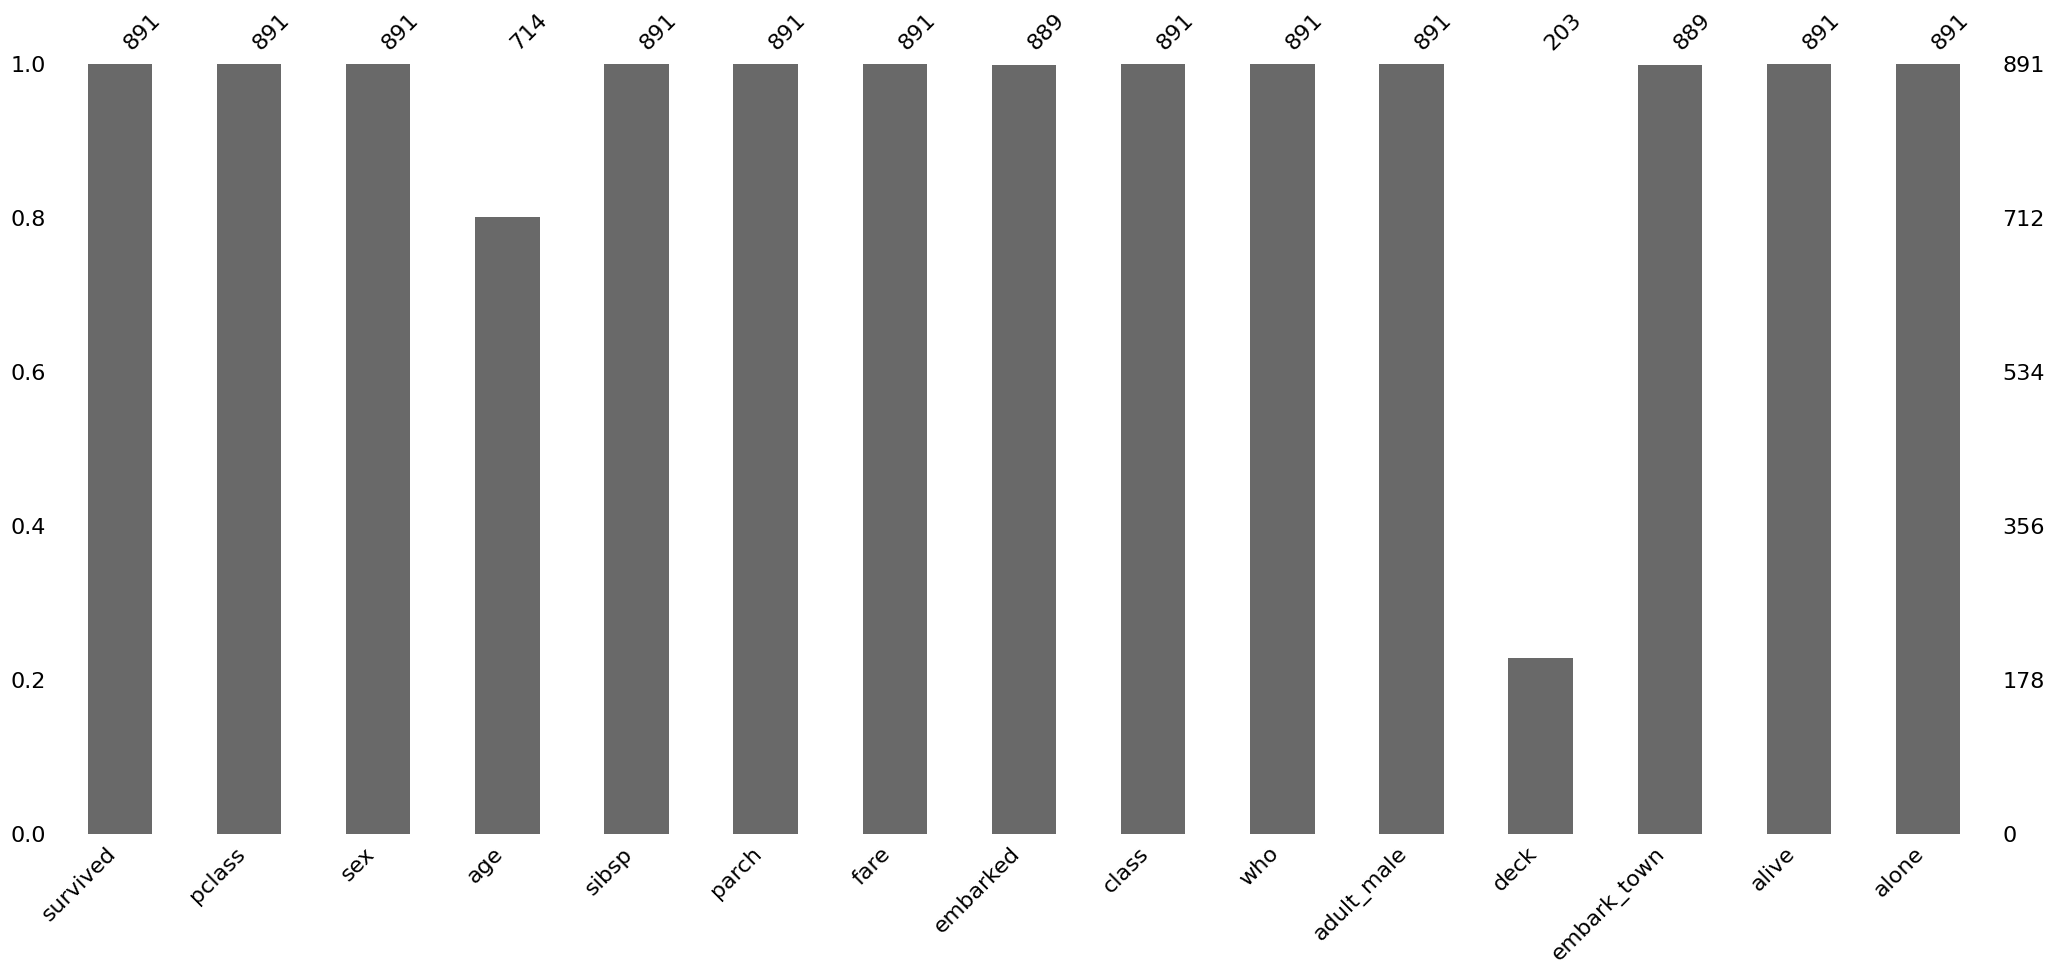

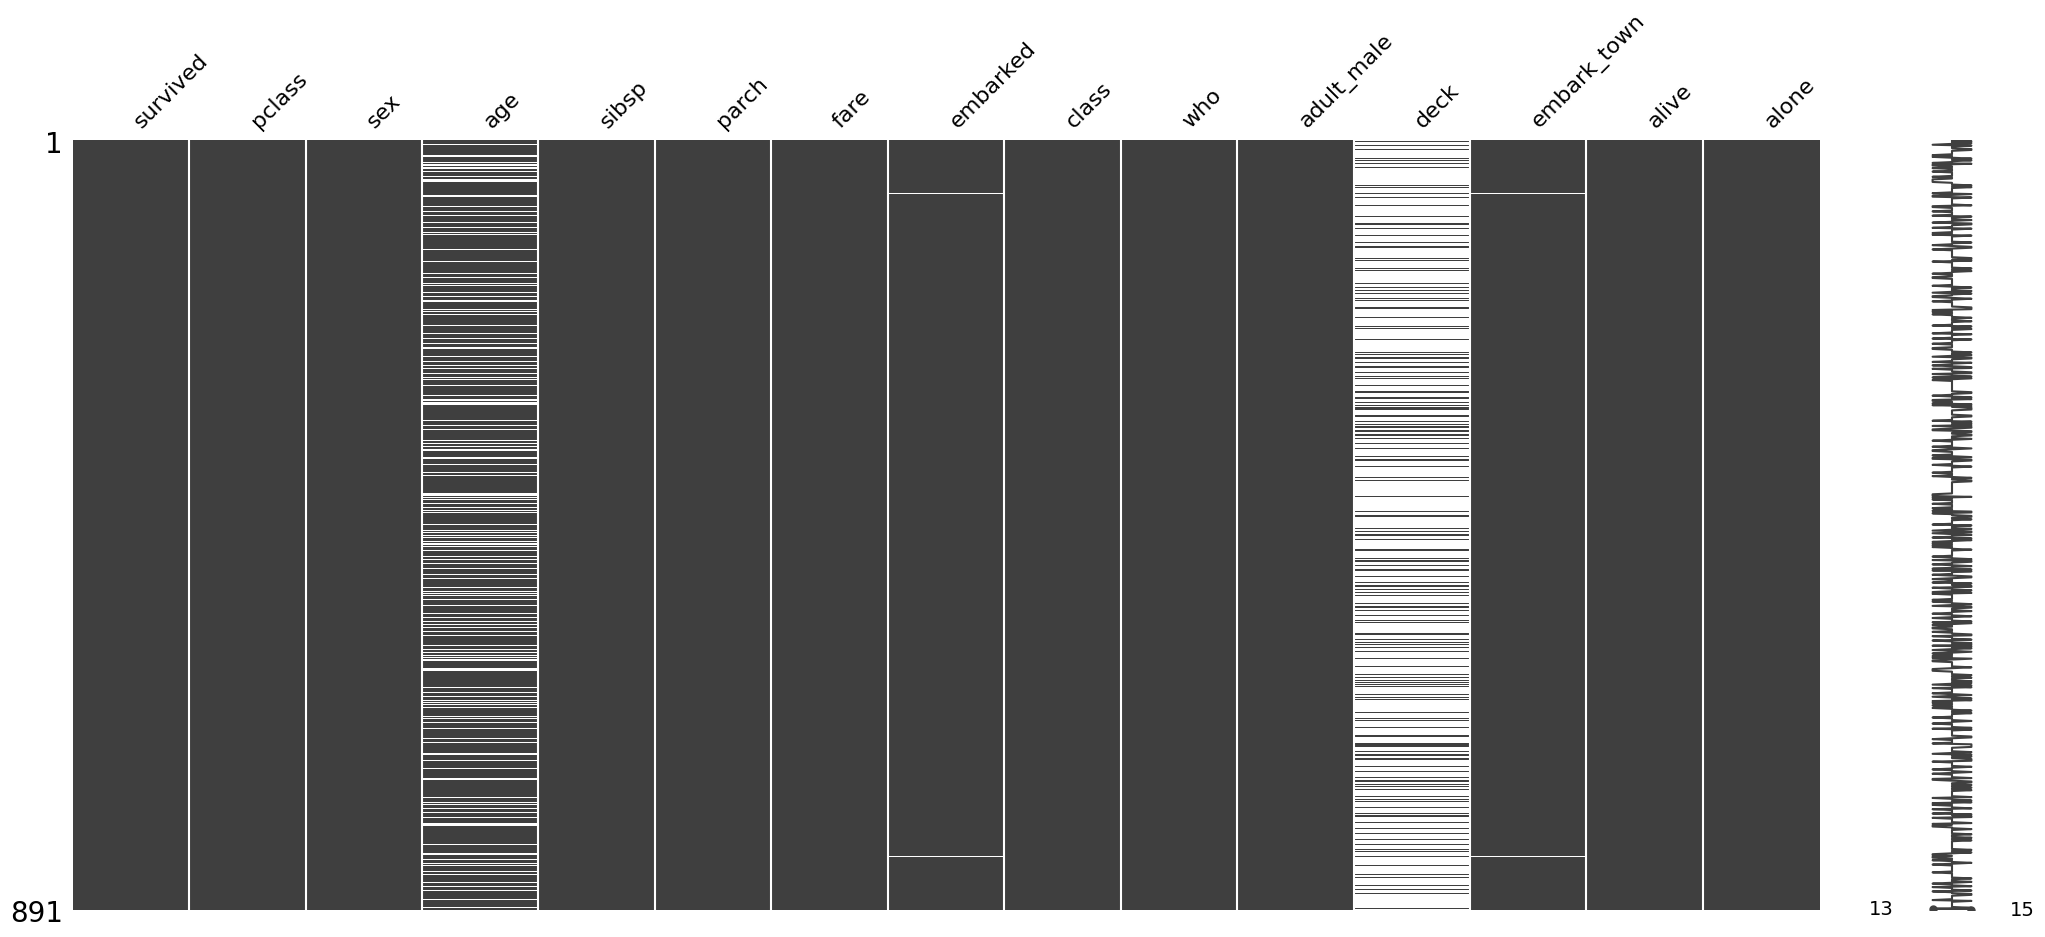

In [24]:
# !pip install missingno  # in case you need to install the package
import missingno as msno

# visualization of available/missing data
msno.bar(titanic)
msno.matrix(titanic)

### Removing data
We have discussed that removing data is typically not ideal, but nothing stops us from doing that...

<Axes: >

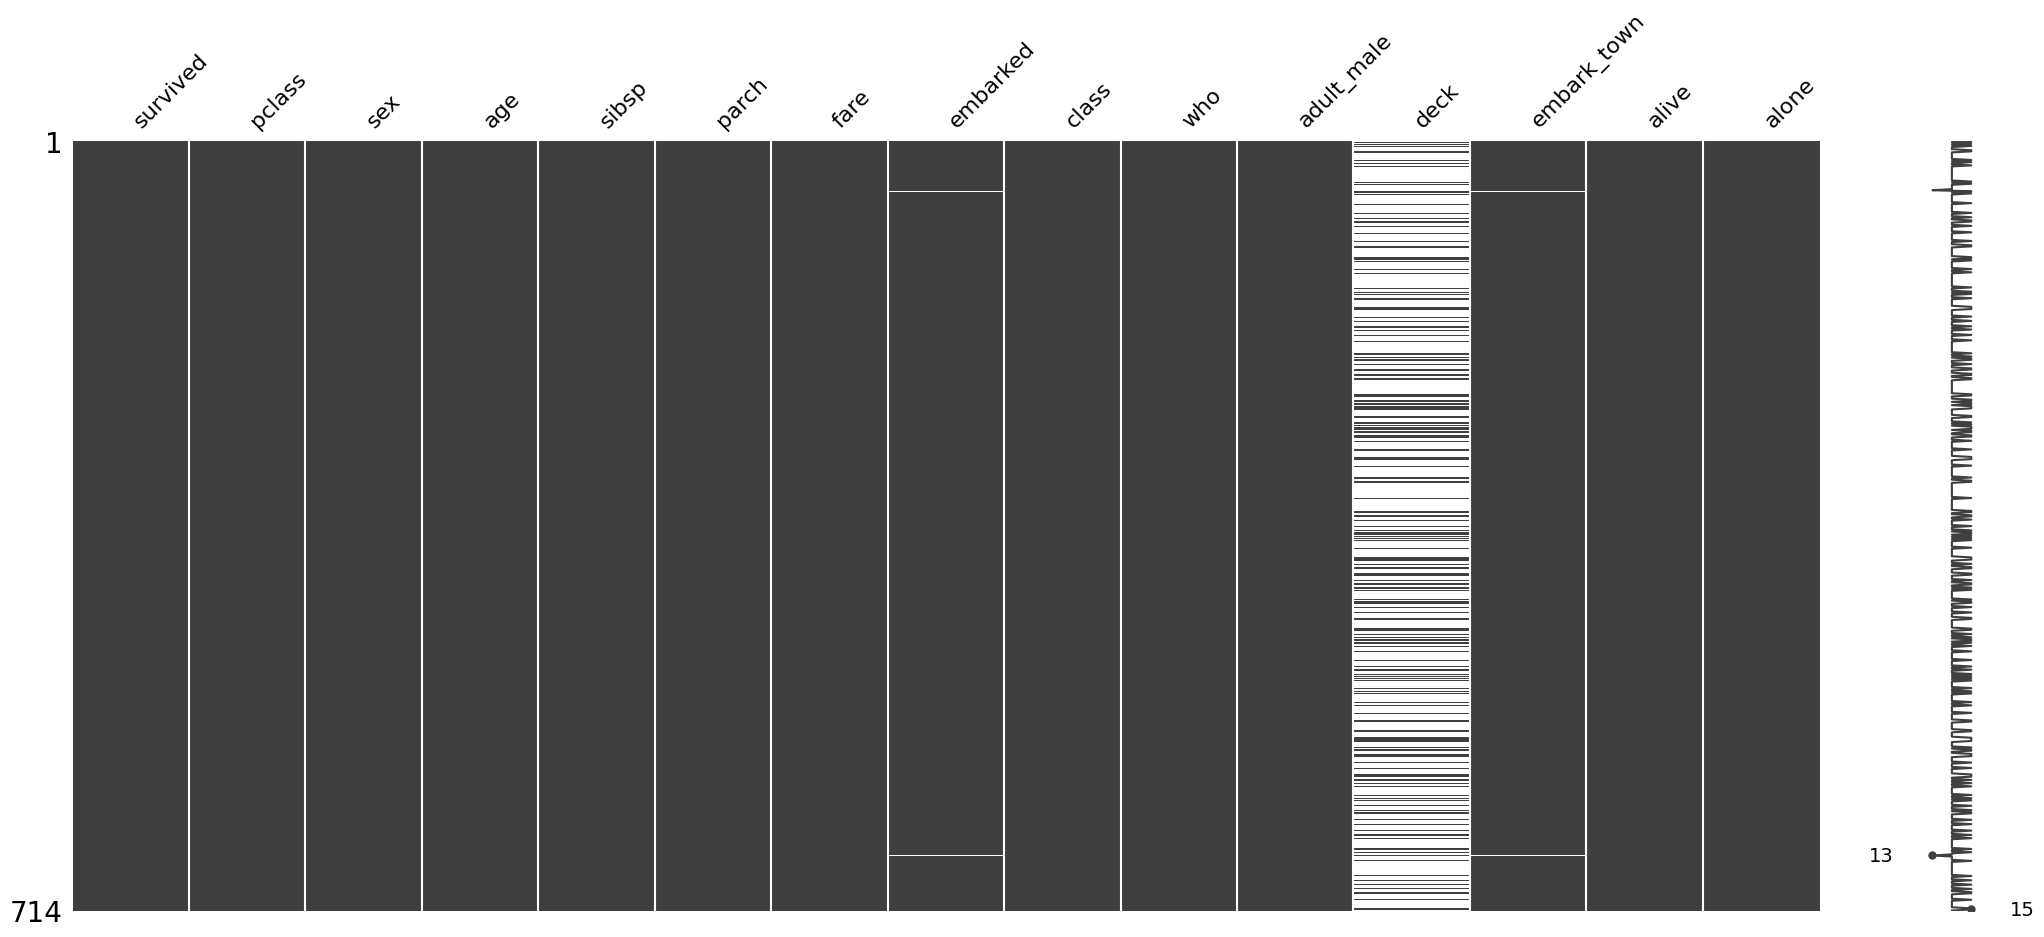

In [25]:
titanic_agecomp = titanic.dropna(subset='age', how='any')
msno.matrix(titanic_agecomp)

In [35]:
corr = titanic.select_dtypes('number').corr()
corr_agecomp = titanic_agecomp.select_dtypes('number').corr()

# changes in correlation matrix with / without age missingness
corr - corr_agecomp

,survived,pclass,age,sibsp,parch,fare
survived,0.000,0.021,0.0,-0.018,-0.012,-0.011
pclass,0.021,0.000,0.0,0.016,-0.007,0.005
age,0.000,0.000,0.0,0.000,0.000,0.000
sibsp,-0.018,0.016,0.0,0.000,0.031,0.021
parch,-0.012,-0.007,0.0,0.031,0.000,0.011
fare,-0.011,0.005,0.0,0.021,0.011,0.000


### Simple imputation with a constant

In [48]:
# !pip install scikit-learn
from sklearn.impute import SimpleImputer
constant_imputer = SimpleImputer(strategy='constant')  # 'median', 'most_frequent', 'constant'

<Axes: ylabel='Frequency'>

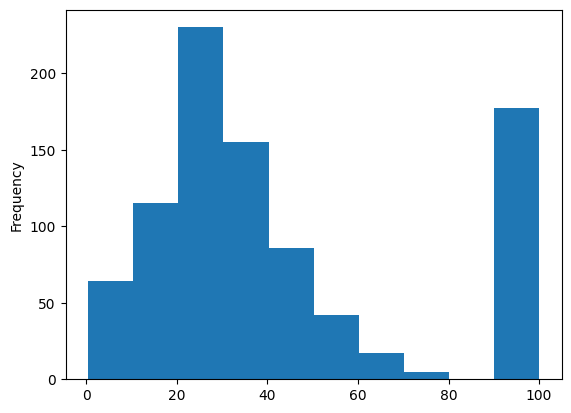

In [55]:
titanic_constant = titanic.copy()

# set constant
constant_imputer.fill_value = 100
titanic_constant.iloc[:,:] = constant_imputer.fit_transform(titanic_constant)

titanic_constant['age'].plot.hist()

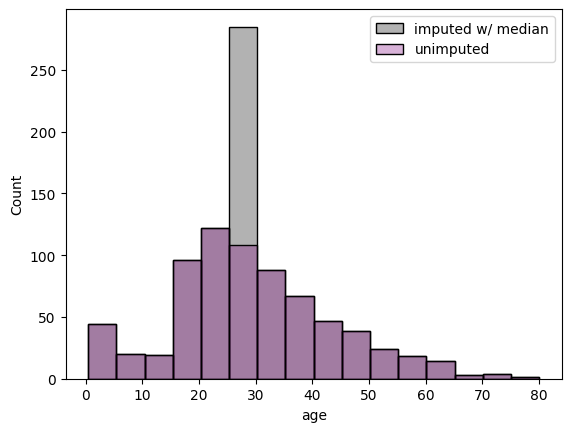

In [62]:
# example with median, admitting only numeric columns
titanic_median = titanic.copy()
titanic_median['age'] = median_imputer.fit_transform(titanic_median[['age']])
# another option
# titanic_median['age'] = titanic_median['age'].fillna(titanic_median['age'].median())

fig, ax = plt.subplots(1, 1)
sns.histplot(titanic_median['age'], binwidth=5, alpha=0.3, color='k', label='imputed w/ median')
sns.histplot(titanic['age'], binwidth=5, alpha=0.3, color='purple', label='unimputed')
ax.legend()

### Simple imputation within a time series
In a time series, imputation can take information from the data before and after the missing location.

Common imputation methods are:
- last observed carried forward, or `ffill`
- Kalman filter
- backfill, or `bfill`
- linear interpolation

### Multiple imputation
Multiple imputation is a technique to generate multiple realizations of imputation values, often modeled by a probability distribution.

One method is the multiple imputation by chained equations, or MICE. `miceforest` uses LightBGM as its training algorithm for MICE.

In [66]:
# !pip install miceforest
import miceforest as mf

# miceforest requires a real matrix. 
# For illustrative purposes, we only use the numerical columns.

# set up a kernel to produce `num_datasets` imputed datasets
num_datasets = 4
kernel = mf.ImputationKernel(
  titanic.select_dtypes('number'),
  datasets=num_datasets,
  save_all_iterations=False,
  random_state=1
)

In [ ]:
# run the MICE algorithm
kernel.mice(iterations=10)

In [68]:
titanic_mf = kernel.complete_data
titanic_mf

<bound method ImputedData.complete_data of 
              Class: ImputationKernel
           Datasets: 4
         Iterations: 10
       Data Samples: 891
       Data Columns: 6
  Imputed Variables: 1
save_all_iterations: True>

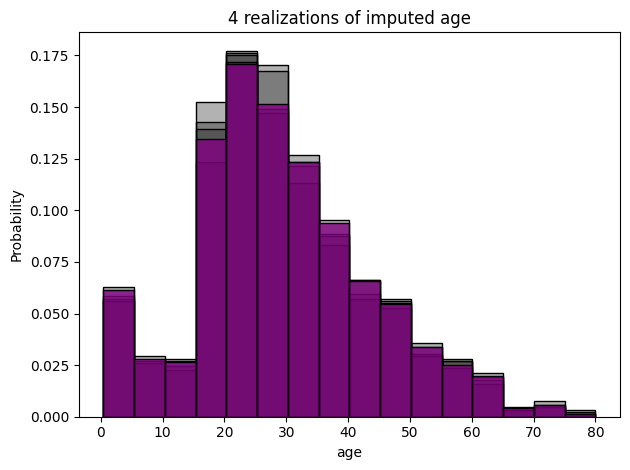

In [78]:
# retrieving each imputed dataset
import matplotlib.pyplot as plt

for k in range(num_datasets):
    sns.histplot(titanic_mf(dataset=k)['age'], binwidth=5, stat='probability', color='k', alpha=0.3)

sns.histplot(titanic['age'], binwidth=5, stat='probability', color='purple', alpha=0.8)

plt.title('{:d} realizations of imputed age'.format(num_datasets))
plt.tight_layout()

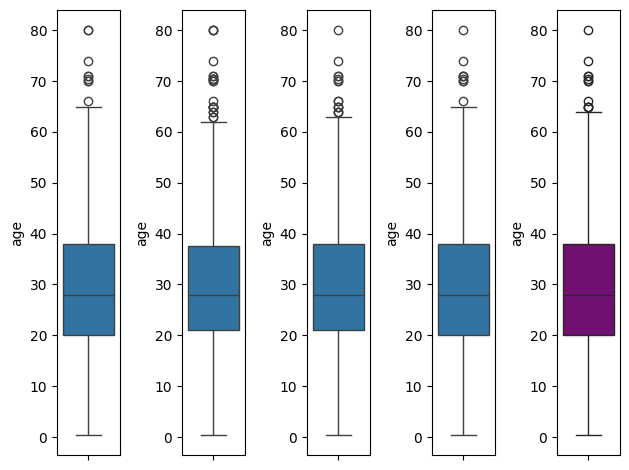

In [86]:
fig, ax = plt.subplots(ncols=5)

for k, axi in enumerate(ax.flatten()):
    if k < num_datasets:
        sns.boxplot(titanic_mf(dataset=k)['age'], ax=axi)
    else:
        sns.boxplot(titanic['age'], ax=axi, color='purple')

plt.tight_layout()

### $k$ Nearest Neighbor

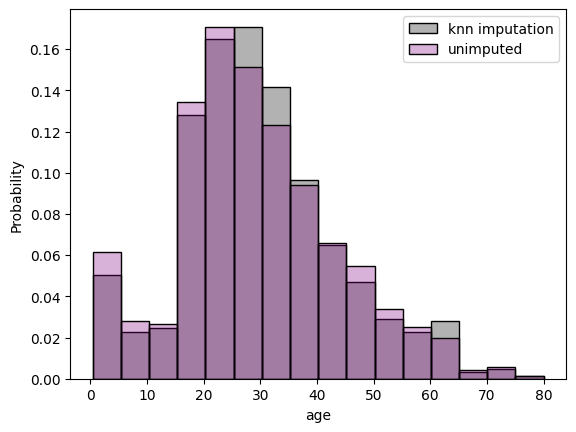

In [12]:
from sklearn.impute import KNNImputer
titanic_knn = titanic.select_dtypes('number').copy()

knn_imputer = KNNImputer(n_neighbors=3)
titanic_knn_impute = knn_imputer.fit_transform(titanic_knn)
titanic_knn_df = pd.DataFrame(titanic_knn_impute, columns=titanic_knn.columns)

fig, ax = plt.subplots(1, 1)
sns.histplot(titanic_knn_df['age'], binwidth=5, stat='probability', alpha=0.3, color='k', label='knn imputation')
sns.histplot(titanic['age'], binwidth=5, stat='probability', alpha=0.3, color='purple', label='unimputed')
ax.legend()

### Matrix completion
Matrix completion typically assumes some low-rank structure within the dataset.  

Examples of usage:
- recommendation system, *see* {ref}`ex-rec-system`.
- image restoration

#### Alternating Least Squares
One particular algorithm that has garnered considerable interest is the Alternating Least Squares algorithm {cite:p}`hastie2015matrix`.

Suppose we have a matrix $R \in \mathbb{R}^{n\times p}$ that contains user ratings for items.  The matrix completion or factorziation problem typically solves for some matrices $X \in \mathbb{R}^{k\times n}, Y \in \mathbb{R}^{k\times p}$ such that $R \approx X^\mathsf{T} Y$, through the optimization problem

$$ \min_{X, Y} \ell(X, Y) := \underbrace{\frac{1}{2} \|P_\Omega(R - X^\mathsf{T} Y)\|^2_F}_\text{recovery} + \underbrace{\frac{\lambda}{2} (\|X\|^2_F + \|Y\|^2_F)}_\text{regularization}, $$

where $P_\Omega$ is a projection that fills in (or discards) missing locations.

**Observation**:  
- $\ell(X, Y)$ is non-convex.
- $\ell(X, Y)$ is bi-convex, meaning that fixing either $X$, or $Y$ leads to a convex function.

The bi-convexity leads to an alternating algorithm (for a full $R$).  But the missing locations do introduce nuances to the algorithm.  See details in Theorem 3.1 of {cite:t}`hastie2015matrix`.

## Some useful additional resources

- [Gary King: Analyzing Incomplete Political Science Data](https://gking.harvard.edu/files/evil.pdf)
- Zangerle, E., & Bauer, C. (2022). Evaluating recommender systems: survey and framework. ACM Computing Surveys, 55(8), 1-38.

```{bibliography}
:filter: docname in docnames
```